# Условные случайные поля для извлечения именнованных сущностей 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Данные

In [3]:
import pandas as pd

df = pd.read_csv('../data/ner.csv', encoding = "ISO-8859-1", error_bad_lines=False)

df.head(10)

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


In [4]:
%%time
def to_sents(df):
    sents = []
    sent = []
    for index, item in df.iterrows():
        if (item.word in ['.', '?', '!', '...']):
            sent.append(tuple((str(item.word), str(item.lemma), str(item.pos), str(item.tag))))
            sents.append(sent)
            sent = []
        else:
            sent.append(tuple((str(item.word), str(item.lemma), str(item.pos), str(item.tag))))
    return(sents)

sents = to_sents(df)
print(*sents[0], sep='\n')

('Thousands', 'thousand', 'NNS', 'O')
('of', 'of', 'IN', 'O')
('demonstrators', 'demonstr', 'NNS', 'O')
('have', 'have', 'VBP', 'O')
('marched', 'march', 'VBN', 'O')
('through', 'through', 'IN', 'O')
('London', 'london', 'NNP', 'B-geo')
('to', 'to', 'TO', 'O')
('protest', 'protest', 'VB', 'O')
('the', 'the', 'DT', 'O')
('war', 'war', 'NN', 'O')
('in', 'in', 'IN', 'O')
('Iraq', 'iraq', 'NNP', 'B-geo')
('and', 'and', 'CC', 'O')
('demand', 'demand', 'VB', 'O')
('the', 'the', 'DT', 'O')
('withdrawal', 'withdraw', 'NN', 'O')
('of', 'of', 'IN', 'O')
('British', 'british', 'JJ', 'B-gpe')
('troops', 'troop', 'NNS', 'O')
('from', 'from', 'IN', 'O')
('that', 'that', 'DT', 'O')
('country', 'countri', 'NN', 'O')
('.', '.', '.', 'O')
CPU times: user 3min 2s, sys: 4.23 s, total: 3min 6s
Wall time: 4min 10s


In [5]:
len(sents)

47985

## Признаковое пространство 

In [6]:
def word2features(sent, i):
    word = sent[i][1]
    postag = sent[i][2]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'postag': postag,   
    }
    if i > 0:
        word1 = sent[i-1][1]
        postag1 = sent[i-1][2]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][1]
        postag1 = sent[i+1][2]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:postag': postag1,
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, lemma, postag, label in sent]

def sent2tokens(sent):
    return [token for token, lemma, postag, label in sent]

И вот что получится

In [7]:
sent2features(sents[0])[1]

{'+1:postag': 'NNS',
 '+1:word.lower()': 'demonstr',
 '-1:postag': 'NNS',
 '-1:word.lower()': 'thousand',
 'bias': 1.0,
 'postag': 'IN',
 'word.lower()': 'of'}

Извлекаем признаки из данных

In [8]:
%%time
X = [sent2features(s) for s in sents]
y = [sent2labels(s) for s in sents]

CPU times: user 3.11 s, sys: 302 ms, total: 3.42 s
Wall time: 3.95 s


In [9]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.332, random_state=42)

## Обучение


In [10]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 2min 1s, sys: 1.86 s, total: 2min 3s
Wall time: 2min 23s


## Оценка качества


In [11]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-geo',
 'I-geo',
 'B-gpe',
 'B-tim',
 'I-tim',
 'B-per',
 'I-per',
 'B-org',
 'I-org',
 'I-gpe',
 'B-art',
 'I-art',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

In [12]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='micro', labels=labels)

0.86768683677908709

Результаты по каждому классу:

In [13]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-art      0.815     0.284     0.421       155
      I-art      0.786     0.190     0.306       116
      B-eve      0.714     0.614     0.660       114
      I-eve      0.679     0.509     0.582       108
      B-geo      0.865     0.909     0.886     12539
      I-geo      0.845     0.826     0.835      2507
      B-gpe      0.972     0.926     0.948      5448
      I-gpe      0.870     0.494     0.630        81
      B-nat      0.658     0.417     0.510        60
      I-nat      0.619     0.542     0.578        24
      B-org      0.816     0.760     0.787      6663
      I-org      0.831     0.829     0.830      5269
      B-per      0.879     0.859     0.869      5604
      I-per      0.869     0.929     0.898      5717
      B-tim      0.932     0.878     0.904      6723
      I-tim      0.846     0.773     0.808      2107

avg / total      0.874     0.862     0.866     53235



# Задание
Добавьте новые признаки к признаковому пространству:

* Регистр слова (написано ли оно с заглавной буквы или со строчной);

* Является ли слово последовательностью символов или цифр;

* Суффикс (последние три бувы) и префикс (первые три буквы) слова.

## Оптимизация гиперпараметров


In [14]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=20, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=20, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

CPU times: user 2min 25s, sys: 13.8 s, total: 2min 39s
Wall time: 20min 6s


Best result:

In [15]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.013571136716571309, 'c2': 0.06841307297123192}
best CV score: 0.7014097909814601
model size: 4.54M


### Анализ пространства параметров


Dark blue => 0.689, dark red => 0.7014


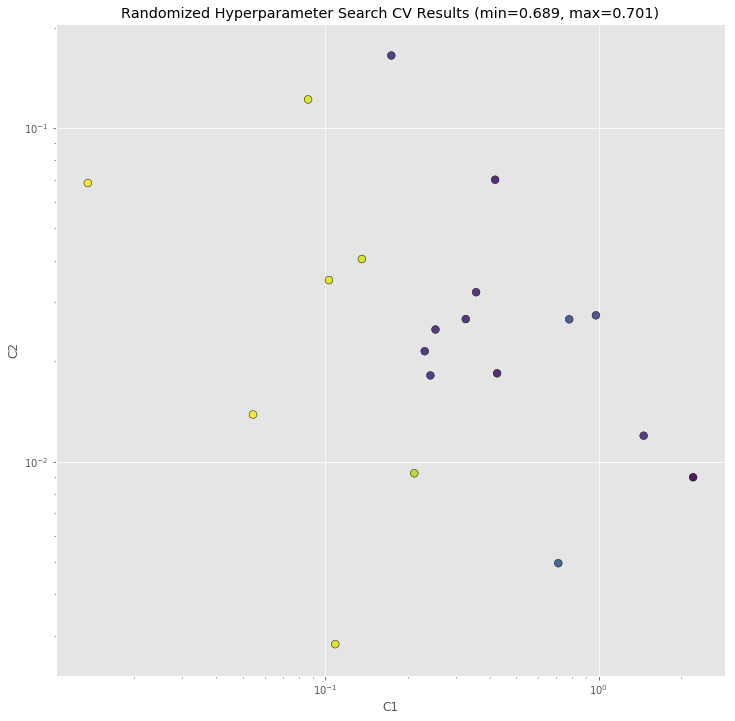

In [16]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Лучшие результаты


In [17]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-art      0.000     0.000     0.000       155
      I-art      0.000     0.000     0.000       116
      B-eve      0.000     0.000     0.000       114
      I-eve      0.000     0.000     0.000       108
      B-geo      0.788     0.794     0.791     12539
      I-geo      0.862     0.497     0.631      2507
      B-gpe      0.950     0.574     0.716      5448
      I-gpe      0.000     0.000     0.000        81
      B-nat      0.000     0.000     0.000        60
      I-nat      0.000     0.000     0.000        24
      B-org      0.585     0.646     0.614      6663
      I-org      0.535     0.767     0.630      5269
      B-per      0.729     0.705     0.717      5604
      I-per      0.756     0.843     0.797      5717
      B-tim      0.831     0.646     0.727      6723
      I-tim      0.717     0.475     0.571      2107

avg / total      0.741     0.691     0.704     53235



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.70402362022756326

## Что выучил классификатор

In [19]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-org  -> I-org   4.265228
B-org  -> I-org   3.948188
I-tim  -> I-tim   3.457920
B-geo  -> I-geo   3.125658
O      -> O       3.022814
B-per  -> I-per   2.993062
B-tim  -> I-tim   2.941580
I-per  -> I-per   2.593775
O      -> B-tim   2.378516
I-geo  -> I-geo   2.196752
O      -> B-geo   1.493673
O      -> B-org   1.388348
O      -> B-per   1.333863
B-geo  -> B-tim   1.060340
B-gpe  -> B-per   0.907217
B-gpe  -> O       0.781815
B-eve  -> I-eve   0.738190
O      -> B-gpe   0.725222
I-tim  -> O       0.690186
B-gpe  -> I-gpe   0.616883

Top unlikely transitions:
B-tim  -> I-org   -1.556650
I-org  -> B-geo   -1.563933
I-per  -> B-per   -1.817250
B-geo  -> B-per   -1.970322
B-per  -> B-per   -2.135875
I-per  -> I-org   -2.547404
B-geo  -> B-geo   -2.618582
I-org  -> I-per   -2.825849
B-org  -> I-per   -2.864779
O      -> I-art   -3.267470
O      -> I-nat   -3.268194
O      -> I-eve   -3.282216
O      -> I-gpe   -3.284273
B-per  -> I-org   -3.379306
B-geo  -> I-per  

In [20]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
5.166357 B-per    word.lower():mr.
5.146314 O        postag:VBD
4.027277 O        postag:VBZ
3.891776 B-gpe    word.lower():iraqi
3.865698 B-gpe    word.lower():palestinian
3.819507 B-tim    word.lower():tuesday
3.580112 B-tim    word.lower():wednesday
3.574672 O        postag:VBN
3.555501 B-tim    word.lower():thursday
3.499301 B-tim    word.lower():friday
3.447589 B-gpe    word.lower():isra
3.433520 B-tim    word.lower():monday
3.425337 B-gpe    postag:NNS
3.341098 B-tim    word.lower():saturday
3.331175 O        EOS
3.328404 O        postag:.
3.323797 O        word.lower():.
3.310670 B-gpe    postag:JJ
3.274410 B-tim    word.lower():sunday
3.127869 O        postag:PRP
3.012922 B-per    word.lower():presid
2.908957 O        BOS
2.865114 B-geo    postag:NNP
2.799254 O        postag:VBG
2.682590 B-geo    word.lower():iraq
2.675381 O        postag:VB
2.638304 B-gpe    word.lower():afghan
2.494175 B-geo    word.lower():u.s.
2.370207 B-gpe    word.lower():american
2.370078 B